# Light Curve Transformations Demo

Here we will demonstrate how we can transform light curves for frequency analysis.

<a target="_blank" href="https://colab.research.google.com/github/zclaytor/lcs_demo/blob/main/transforms_demo.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

In [ ]:
# If running in Colab, install required packages.
%pip install astropy lightkurve

In [1]:
# Download a single light curve from the star Pi Mensae
import numpy as np
import lightkurve as lk
import matplotlib.pyplot as plt

sr = lk.search_lightcurve("pi men", sector=1, author="spoc")
lc = sr.download(download_dir=".")

## Fourier Transform

The Fourier transform requires uniformly sampled data, but is fast and easy to compute. Most Kepler/TESS light curves are very nearly uniformly sampled. 

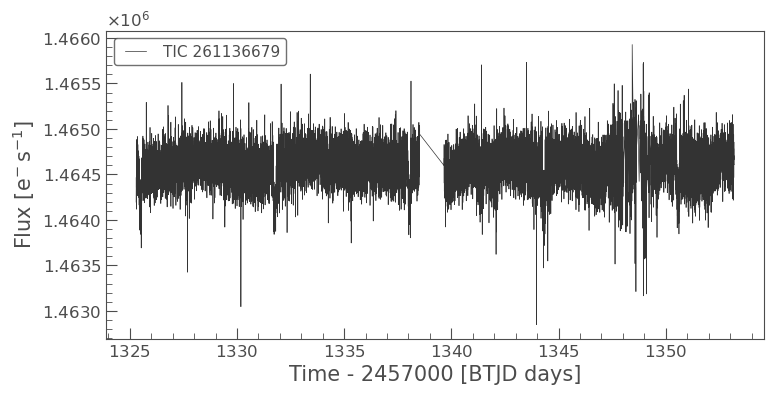

In [2]:
%matplotlib inline
lc.plot();

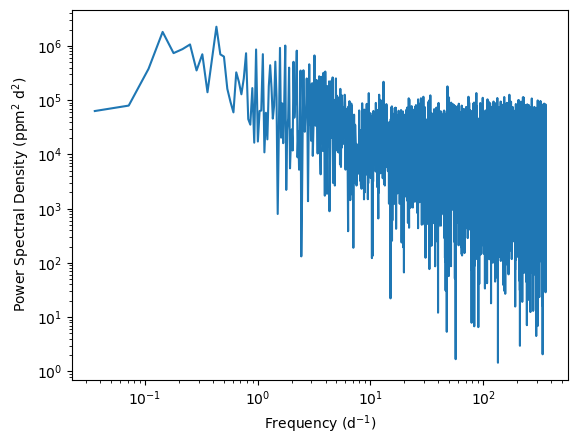

In [3]:
def fourier_transform(lc):
    t = lc.time.value
    y = lc.flux.value
    
    N = len(t)
    frequency = np.fft.fftfreq(N, t[1] - t[0])
    y_fft = np.fft.fft(y)
    positive = (frequency > 0)
    return frequency[positive], (1. / N) * abs(y_fft[positive]) ** 2

l = lc.fill_gaps().normalize() * 1e6
f, psd = fourier_transform(l)

%matplotlib inline
plt.plot(f, psd)
plt.xscale("log")
plt.yscale("log")
plt.xlabel("Frequency (d$^{-1}$)")
plt.ylabel("Power Spectral Density (ppm$^2$ d$^2$)");

## Lomb-Scargle Periodogram

The Lomb-Scargle Periodogram can be thought of as a generaliztation of the FFT to non-uniformly sampled data. In the limit of uniform sampling, the PSD normalization of the LSP *is* the FFT. 

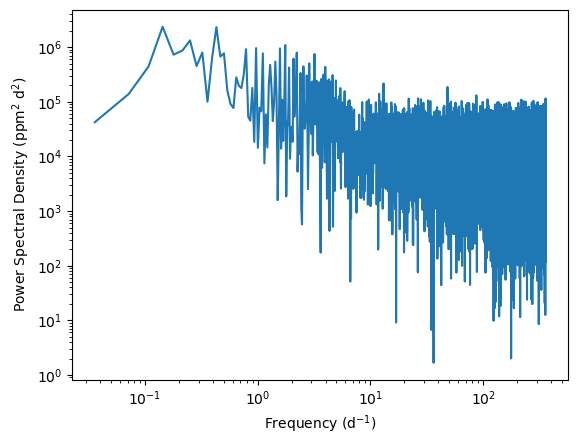

In [4]:
from astropy.timeseries import LombScargle
import astropy.units as u

PSD_LS = LombScargle(lc.time, lc.normalize().flux*1e6).power(f/u.d, normalization="psd")
%matplotlib inline
plt.plot(f, PSD_LS)
plt.xscale("log")
plt.yscale("log")
plt.xlabel("Frequency (d$^{-1}$)")
plt.ylabel("Power Spectral Density (ppm$^2$ d$^2$)");

## Short-Time Fourier Transform

The STFT is computed by convolving a window function with the signal and computing the FFT for the windowed signal. It shows the time evolution of the frequency spectrum.

The example below is taken from the `scipy` documentation.

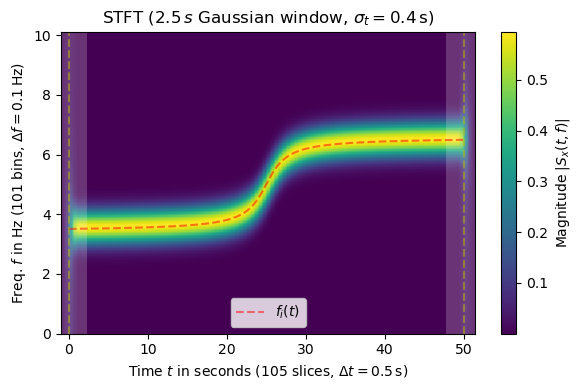

In [5]:
from scipy.signal import ShortTimeFFT
from scipy.signal.windows import gaussian


T_x, N = 1 / 20, 1000  # 20 Hz sampling rate for 50 s signal
t_x = np.arange(N) * T_x  # time indexes for signal
f_i = 1 * np.arctan((t_x - t_x[N // 2]) / 2) + 5  # varying frequency
x = np.sin(2*np.pi*np.cumsum(f_i)*T_x) # the signal


g_std = 8 # standard deviation for Gaussian window in samples
w = gaussian(50, std=g_std, sym=True)  # symmetric Gaussian window
SFT = ShortTimeFFT(w, hop=10, fs=1/T_x, mfft=200, scale_to="psd")
Sx = SFT.stft(x)  # perform the STFT

%matplotlib inline
fig1, ax1 = plt.subplots(figsize=(6., 4.))  # enlarge plot a bit

t_lo, t_hi = SFT.extent(N)[:2]  # time range of plot

ax1.set_title(rf"STFT ({SFT.m_num*SFT.T:g}$\,s$ Gaussian window, " +
              rf"$\sigma_t={g_std*SFT.T}\,$s)")

ax1.set(xlabel=f"Time $t$ in seconds ({SFT.p_num(N)} slices, " +
               rf"$\Delta t = {SFT.delta_t:g}\,$s)",
        ylabel=f"Freq. $f$ in Hz ({SFT.f_pts} bins, " +
               rf"$\Delta f = {SFT.delta_f:g}\,$Hz)",
        xlim=(t_lo, t_hi))

im1 = ax1.imshow(abs(Sx), origin='lower', aspect='auto',
                 extent=SFT.extent(N), cmap='viridis')
ax1.plot(t_x, f_i, 'r--', alpha=.5, label='$f_i(t)$')

fig1.colorbar(im1, label="Magnitude $|S_x(t, f)|$")

# Shade areas where window slices stick out to the side:
for t0_, t1_ in [(t_lo, SFT.lower_border_end[0] * SFT.T),
                 (SFT.upper_border_begin(N)[0] * SFT.T, t_hi)]:
    ax1.axvspan(t0_, t1_, color='w', linewidth=0, alpha=.2)

for t_ in [0, N * SFT.T]:  # mark signal borders with vertical line:
    ax1.axvline(t_, color='y', linestyle='--', alpha=0.5)

ax1.legend()
fig1.tight_layout()

This is a neat example, but how does it look for a light curve?

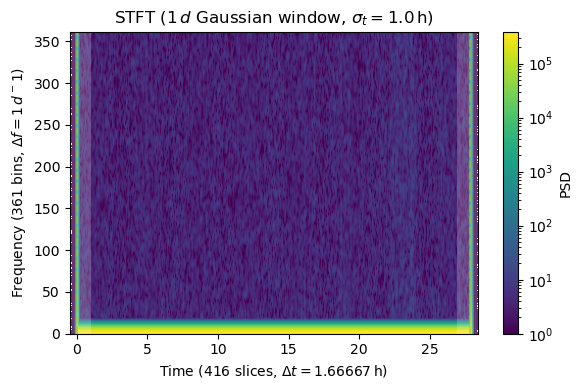

In [6]:
from matplotlib.colors import LogNorm

time = l.time.value
flux = l.flux.value
fs = 720 # 2-minute cadence = 720 samples / day
N = len(time)

g_std = 30 # standard deviation for Gaussian window in samples
w = gaussian(720, std=g_std, sym=True)  # symmetric Gaussian window
SFT = ShortTimeFFT(w, hop=50, fs=fs, scale_to="psd")
Sx = SFT.stft(flux)  # perform the STFT

%matplotlib inline
fig1, ax1 = plt.subplots(figsize=(6., 4.))  # enlarge plot a bit

t_lo, t_hi = SFT.extent(N)[:2]  # time range of plot

ax1.set_title(rf"STFT ({SFT.m_num*SFT.T:g}$\,d$ Gaussian window, $\sigma_t={g_std*SFT.T*24}\,$h)")

ax1.set(xlabel=rf"Time ({SFT.p_num(N)} slices, $\Delta t = {SFT.delta_t*24:g}\,$h)",
        ylabel=rf"Frequency ({SFT.f_pts} bins, $\Delta f = {SFT.delta_f:g}\,d^{-1}$)",
        xlim=(t_lo, t_hi), 
        #yscale="log"
)

im1 = ax1.imshow(abs(Sx), origin='lower', aspect='auto', extent=SFT.extent(N), cmap='viridis', norm=LogNorm(vmin=1))

fig1.colorbar(im1, label="PSD")

# Shade areas where window slices stick out to the side:
for t0_, t1_ in [(t_lo, SFT.lower_border_end[0] * SFT.T), (SFT.upper_border_begin(N)[0] * SFT.T, t_hi)]:
    ax1.axvspan(t0_, t1_, color='w', linewidth=0, alpha=.2)

for t_ in [0, N * SFT.T]:  # mark signal borders with vertical line:
    ax1.axvline(t_, color='y', linestyle='--', alpha=0.5)

fig1.tight_layout()

Well, that's something, but let's try another light curve, one that has clear rotational modulation.

<Axes: xlabel='Time - 2457000 [BTJD days]', ylabel='Flux [$\\mathrm{e^{-}\\,s^{-1}}$]'>

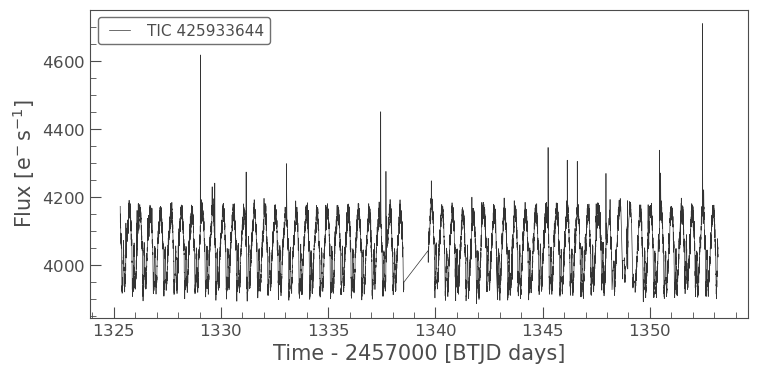

In [7]:
sr = lk.search_lightcurve("TIC 425933644", sector=1, author="spoc")
lc1 = sr.download(download_dir=".")
lc1.plot()

The Lomb-Scargle periodogram has a clear peak at about 2 cycles per day:

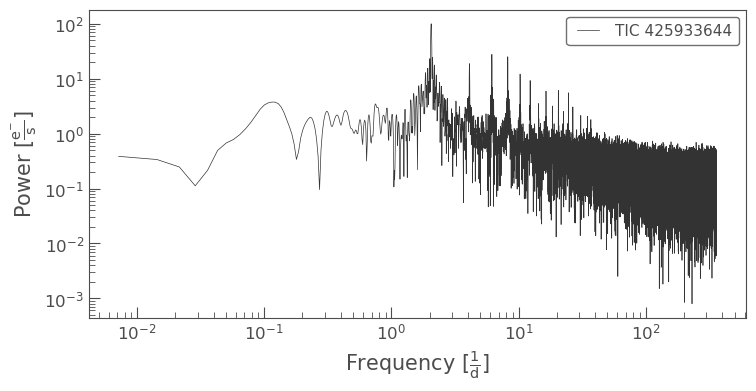

In [8]:
lc1.to_periodogram().plot(scale="log");

Let's see the STFT for this light curve.

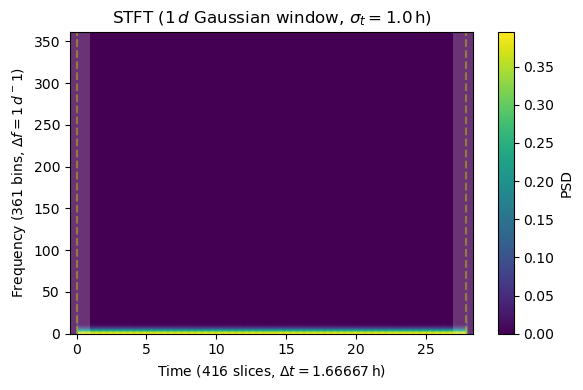

In [9]:
l1 = lc1.fill_gaps().normalize()

time = l1.time.value
flux = l1.flux.value
fs = 720 # 2-minute cadence = 720 samples / day
N = len(time)

g_std = 30 # standard deviation for Gaussian window in samples
w = gaussian(720, std=g_std, sym=True)  # symmetric Gaussian window
SFT = ShortTimeFFT(w, hop=50, fs=fs, scale_to="psd")
Sx = SFT.stft(flux)  # perform the STFT

%matplotlib inline
fig1, ax1 = plt.subplots(figsize=(6., 4.))  # enlarge plot a bit

t_lo, t_hi = SFT.extent(N)[:2]  # time range of plot

ax1.set_title(rf"STFT ({SFT.m_num*SFT.T:g}$\,d$ Gaussian window, $\sigma_t={g_std*SFT.T*24}\,$h)")

ax1.set(xlabel=rf"Time ({SFT.p_num(N)} slices, $\Delta t = {SFT.delta_t*24:g}\,$h)",
        ylabel=rf"Frequency ({SFT.f_pts} bins, $\Delta f = {SFT.delta_f:g}\,d^{-1}$)",
        xlim=(t_lo, t_hi), 
        #yscale="log"
)

im1 = ax1.imshow(abs(Sx), origin='lower', aspect='auto', extent=SFT.extent(N), cmap='viridis')

fig1.colorbar(im1, label="PSD")

# Shade areas where window slices stick out to the side:
for t0_, t1_ in [(t_lo, SFT.lower_border_end[0] * SFT.T), (SFT.upper_border_begin(N)[0] * SFT.T, t_hi)]:
    ax1.axvspan(t0_, t1_, color='w', linewidth=0, alpha=.2)

for t_ in [0, N * SFT.T]:  # mark signal borders with vertical line:
    ax1.axvline(t_, color='y', linestyle='--', alpha=0.5)

fig1.tight_layout()

The STFT is a nice way to see changes in the frequency spectrum. However, many interesting light curve features are at low frequencies, and this implementation of STFT doesn't appear to give any control over the frequencies at which the transform is computed.

Let's try one other transform, the Continuous Wavelet Transform.

## Continuous Wavelet Transform

Similar to the STFT, the CWT shows temporal changes in the frequency spectrum. It's also produced by convolving a window function with the signal, but instead of a Gaussian it uses one of several wavelets. The most common used in stellar rotation analysis is the Morlet wavelet.

I have my own implementation of the CWT, which wraps the `scipy` implementation and provides convenience functions for plotting.

In [134]:
%pip install git+https://github.com/zclaytor/prot

  Cloning https://github.com/zclaytor/prot to /private/var/folders/s5/mzsl79_56tlczq9y98qqm33w0005sm/T/pip-req-build-igh90x3v
  Running command git clone --filter=blob:none --quiet https://github.com/zclaytor/prot /private/var/folders/s5/mzsl79_56tlczq9y98qqm33w0005sm/T/pip-req-build-igh90x3v
  Resolved https://github.com/zclaytor/prot to commit 0fd80facaa79f8539bce91a3f531d8792a0ce167
  Preparing metadata (setup.py) ... done
  Created wheel for prot: filename=prot-0.1.4a0-py3-none-any.whl size=6431 sha256=4eff0565f2f175d246d6f9112287faada983f1c0c1071dbd4e2c55cf28f6e179
  Stored in directory: /private/var/folders/s5/mzsl79_56tlczq9y98qqm33w0005sm/T/pip-ephem-wheel-cache-_ucfh8_t/wheels/27/16/7f/f213cd19d0c4cc09bd320a1db112a690a93d9bd3adc9ae5079
Successfully built prot
Note: you may need to restart the kernel to use updated packages.


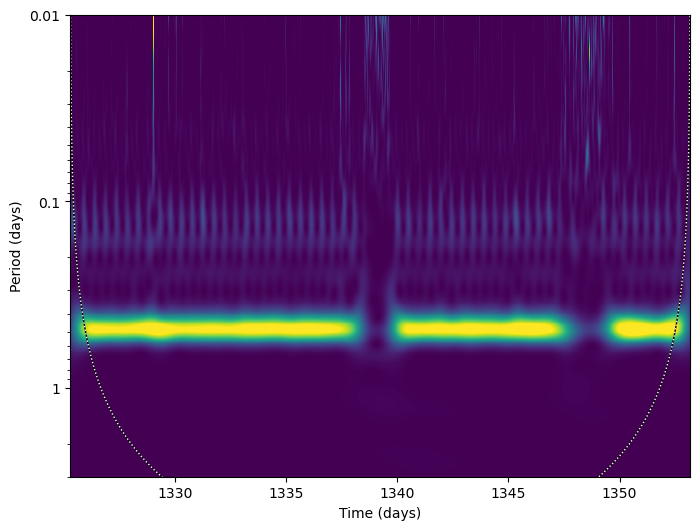

In [10]:
from prot import WaveletTransform as WT

wt = WT.from_lightcurve(l1, minimum_period=0.01, maximum_period=3, w=6)
%matplotlib inline
fig, ax = plt.subplots(figsize=(8, 6))
wt.plot(ax=ax, cmap="viridis", vmin=1e-10, vmax=5e-4);

Because we have control over what frequencies are used for the CWT computation, we can use this to see interesting features in the light curve power spectrum.

## S Transform

There apparently exists another thing called the "S transform" which balances some features of the STFT and the CWT. I know nothing about it besides what's on the [wikipedia page](https://en.wikipedia.org/wiki/S_transform), but it may be worth looking at.

## Summary

We've looked at four different frequency spectra:
- Fourier Transform (FFT)
- Lomb-Scargle Periodogram (LSP)
- Short-Time Fourier Transform (SFTF)
- Continuous Wavelet Transform (CWT)

Some pros and cons:
- only the LSP will work on non-uniformly sampled data (i.e., gaps or missing cadences). However, most Kepler and TESS data are close enough to uniform sampling that it doesn't make much of a difference.
- The STFT and CWT let us see how the frequency spectrum changes with time, whereas the FFT and LSP show averages over the whole light curve.
- The STFT implementation doesn't appear to give any control for what frequencies the power spectrum is computed, so it seems like we can't view the power spectrum on a logarithmic scale, for example. The CWT *does* let us do this.
- The CWT is somewhat computationally expensive, and takes longer to compute than the STFT. I'll do some tests to quantify how much.

I've had good experience using the CWT representation for inferring rotational frequency information with Convolutional Neural Networks. That doesn't mean other methods won't be as useful or even more useful. But we may want to consider:
- computational efficiency
- which representation actually shows information we want to learn
- memory efficiency for large data sets